### Read SCREAM CESS data

Andrew Gettelman, Feb 2025

This code is designed to multiply write 2D 3hourly fields stored as ne1024


In [1]:
import healpix as hp
import numpy as np
import xarray as xr
import numcodecs
import zarr

import easygems.healpix as egh
import easygems.remap as egr

import matplotlib.pyplot as plt

import dask.array as da

import glob

### Basic Data parameters

	0. output.scream.Cess.50hourly_QcQiNcNi.INSTANT.nhours_x50.*
		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
		- nc, ni, qc, qi
	1. output.scream.Cess.50hourly_QrNrQmBm.INSTANT.nhours_x50.2020-08-31-72000.nc
		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
		- bm, nr, qm, qr. (What is 'm'? Mixed? What is variable bm?)
	2. output.scream.Cess.hourly2DVars.INSTANT.nhours_x1.*
		- 49 times, hourly, raw 3km output (25M columns)
		- Precip, olr
	3. output.scream.Cess.6hourlyINST_ne30.INSTANT.nhours_x6.2020-08-31-21600.nc
		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels
		- 2D: IWP, LWP, RH, T_2m, WV_path, ps, 
		- 3D: T_mid,horiz winds (dim2=U.v?), omega, O3, qc, qv, tke
		- Static: landfrac, oceanfrac
	4. output.scream.Cess.6hourlyAVG_ne30.AVERAGE.nhours_x6.2020-08-31-00000.nc
		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels (don't need them)
		- Lots of low res variables
    5. 3hourlyAVG_ne120.AVERAGE.nhours_x3.
        - Ne120 (25km), 3hrly, 221 levels
        - 2D and 3D variables
    6. cess-oct2.elm.h1.
        - Daily land output on native land grid (swe, soil moisture)

In [2]:
### Path and data sets

rfn='cess-control.ne1024pg2_ne1024pg2.F2010-SCREAMv1.cess-oct2/run/'
fn='/global/cfs/cdirs/e3sm/gsharing/EAMxx/Cess/SCREAM3km/'+rfn

### Prefixes for 'Streams'

outpre='output.scream.Cess.'

fprefix=[]

fprefix.append('50hourly_QcQiNcNi.INSTANT.nhours_x50.')
#		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
#		- nc, ni, qc, qi

fprefix.append('50hourly_QrNrQmBm.INSTANT.nhours_x50.')
#		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
#		- bm, nr, qm, qr. (What is 'm'? Mixed? What is variable bm?)

fprefix.append('hourly2DVars.INSTANT.nhours_x1.')
#		- 49 times, hourly, raw 3km output (25M columns)
#		- Precip, olr

fprefix.append('6hourlyINST_ne30.INSTANT.nhours_x6.')
#		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels
#		- 2D: IWP, LWP, RH, T_2m, WV_path, ps, 
#		- 3D: T_mid,horiz winds (dim2=U.v?), omega, O3, qc, qv, tke
#		- Static: landfrac, oceanfrac

fprefix.append('6hourlyAVG_ne30.AVERAGE.nhours_x6.')
#		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels (don't need them)
#		- Needed variables (All 2D): LW flux at bot (up,down), LW flux up at top, SW dwn/up at top/bot (4)
#            horiz wind at bottom (U,V), ice_precip, liq_precip, ps, surf_evap, surf_mom (u,v), surf_T, 
#            surf sens_flux, upward LHF

fprefix.append('3hourlyAVG_ne120.AVERAGE.nhours_x3.')
#       - Ne 120 (25km), 24 times, 3 hourly, 221 levels
#       - Lots of variables could be used here (2D rad fluxes, Tmp, precip, ps) (3D qc,qi,qr,qv,z,omega, winds)
#       - most of what is needed is here!

fprefix.append('cess-control.ne1024pg2_ne1024pg2.F2010-SCREAMv1.cess-oct2.elm.h1.')
#       - Daily land files on native land grid (25M columns): H2OSNO, SOILWATER_10CM


In [3]:
st=5

if (st==6):
    fspec=fn+fprefix[st]+'*.nc'
else:
    fspec=fn+outpre+fprefix[st]+'*.nc'

file_list= glob.glob(fspec)

# Sort it by time
sorted_files = sorted(file_list)


In [4]:
%%time
## Issues: 
# for ne30 data (s=3 and 4) one file has a day extra data (one file is 2 days apart, but has 3 days of data)
## So load it twice, and then append...

## Still issues with hourly data on native grid (s=2) [need to sort that out]. 

if (st == 5):
    del sorted_files[70]
    ds0=xr.open_mfdataset(sorted_files[:69])
    ds1=xr.open_mfdataset(sorted_files[69:])
    ds_scream=xr.concat([ds0,ds1.isel(time=slice(8,1536))],dim='time')
    del ds0,ds1
    
if (st == 3) or (st==4):
    ds0=xr.open_mfdataset(sorted_files[:69])
    ds1=xr.open_mfdataset(sorted_files[69:])
    ds_scream=xr.concat([ds0,ds1.isel(time=slice(4,1529))],dim='time')
    del ds0,ds1

if (st < 2) or (st==6):
    ds_scream=xr.open_mfdataset(sorted_files)


CPU times: user 4.18 s, sys: 547 ms, total: 4.73 s
Wall time: 1min 23s


### Vertical Information

In [5]:
### Vertical Levels for s=3,5 (221)
#levfile='/global/cfs/cdirs/e3sm/gsharing/EAMxx/Cess/SCREAM3km/grids/vrt_remapping_p_levs_20230926.nc'
#slev=xr.open_dataset(levfile)

In [6]:
### Vertical levels to interpolate to.
#tr = np.arange(100,900,100)
#lt = np.arange(850,1025,25)
#ua = np.arange(10,90,20)
#levels = sorted({1,5,20,150,250,750}.union(tr,lt,ua))
#levels = [int(x) for x in levels]

In [7]:
#ds_scream=ds_scream.assign_coords({"lev":slev.p_levs.values/100.})

In [8]:
#ds_scream=ds_scream.interp(lev=levels)

In [9]:
# Do this once for each stream to get a list of things in the file
#list(ds_scream.keys())

### Process data
Focus on 2D fields, will loop over varn2D here

In [10]:
if(st==3):
    varn2D=['IceWaterPath','LiqWaterPath','VapWaterPath','T_2m','landfrac','ocnfrac',
            'qv_2m','surf_radiative_T','ps']
    varn3D=['T_mid','omega','RelativeHumidity','qc','qi','qr','qv','tke']
    varn4D=['horiz_winds']

if(st==5):
    varn2D=['LW_clrsky_flux_dn_at_model_bot','LW_clrsky_flux_up_at_model_top', 'LW_flux_dn_at_model_bot',
            'LW_flux_up_at_model_bot','LW_flux_up_at_model_top','LongwaveCloudForcing',
            'SW_clrsky_flux_dn_at_model_bot','SW_clrsky_flux_up_at_model_bot','SW_clrsky_flux_up_at_model_top',
            'SW_flux_dn_at_model_bot','SW_flux_dn_at_model_top','SW_flux_up_at_model_bot',
            'SW_flux_up_at_model_top','ShortwaveCloudForcing',
            'T_2m','precip_ice_surf_mass_flux','precip_liq_surf_mass_flux','ps',
            'sfc_flux_lw_dn','sfc_flux_sw_net','surf_evap','surf_radiative_T',
            'surf_sens_flux','surface_upward_latent_heat_flux','qv_at_model_bot',
            'uas','vas','tauu','tauv','clt']
# Mapping names
    varn2Dout=['rldscs','rlutcs', 'rlds',
            'rlus','rlut','lwcre',
            'rsdscs','rsuscs','rsutcs',
            'rsds','rsdt','rsus',
            'rsut','swcre',
            'tas','prs','pr','ps',
            'sfc_flux_lw_dn','sfc_flux_sw_net','surf_evap','ts',
            'hfssd','hflsd','huss',
            'uas','vas','tauu','tauv','clt']
    
#    varn2Dvec=['horiz_winds_at_model_bot','surf_mom_flux']
#    varn2DvecOut=['uas','vas','tauu','tauv']
    
    varn3D=['T_mid','omega','qc','qv','z_mid']

    varn3Dout=['ta','omega','qall','hus','zg']  #qall=qc+qi+qr
    
    varn3Dvec=['horiz_winds']

    varn3DvecOut=['ua','va']
    
if(st==6):
    varn2D=['H2OSNO','SOILWATER_10CM']
    varn2Dout=['swe','mrso']

### Unwrap vector fields

In [11]:
# 10m wind
ds_scream['uas']=ds_scream.horiz_winds_at_model_bot.isel(dim2=0)
ds_scream['vas']=ds_scream.horiz_winds_at_model_bot.isel(dim2=1)
# surface stress
ds_scream['tauu']=ds_scream.surf_mom_flux.isel(dim2=0)
ds_scream['tauv']=ds_scream.surf_mom_flux.isel(dim2=1)

In [12]:
### Cloud fraction (total)
# take max of cloud fraction in the vertical... 
ds_scream['clt']=ds_scream.cldfrac_tot.max(dim='lev')


### Reduce data needed variables

In [13]:
#Shrink Array to what is needed

# Map and rename variables
rename_dict = dict(zip(varn2D, varn2Dout))
ds_scream=ds_scream.rename(rename_dict)

### Save off lat and lon

slon=ds_scream.lon.isel(time=0)
slat=ds_scream.lat.isel(time=0)

### Keep only the needed variables

ds_scream=ds_scream[varn2Dout]

In [14]:
ds_scream

<xarray.Dataset> Size: 131GB
Dimensions:          (time: 3168, ncol: 345600)
Coordinates:
  * time             (time) object 25kB 2019-08-01 03:00:00 ... 2020-09-01 00...
Dimensions without coordinates: ncol
Data variables: (12/30)
    rldscs           (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    rlutcs           (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    rlds             (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    rlus             (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    rlut             (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    lwcre            (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    ...               ...
    huss             (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    uas              (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    vas              (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    tauu             (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    tauv             (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
    clt              (time, ncol) float32 4GB dask.array<chunksize=(16, 345600), meta=np.ndarray>
Attributes: (12/22)
    institutions:                 LLNL (Lawrence Livermore National Laborator...
    case_t0:                      2019-08-01-00000
    run_t0:                       2019-08-01-00000
    averaging_type:               AVERAGE
    averaging_frequency_units:    nhours
    averaging_frequency:          3
    ...                           ...
    contact:                      e3sm-data-support@llnl.gov
    institution_id:               E3SM-Projet
    realm:                        atmos
    history:                      created on Sun Oct  8 17:33:21 2023
    Conventions:                  CF-1.8
    product:                      model-output

In [15]:
nv=len(varn2Dout)
nv

30

### Helper Functions for Zarr Encoding

In [16]:
# Single Precision for Floats

def get_dtype(da):
    if np.issubdtype(da.dtype, np.floating):
        return "float32"
    else:
        return da.dtype
    
    
# Chunking (note, 'cell' has to match name of column dimension in input)

def get_chunks(dimensions):
    if "level" in dimensions:
        chunks = {
            "time": 24,
            "cell": 4**5,
            "level": 4,
        }
    else:
        chunks = {
            "time": 24,
            "cell": 4**6,
        }

    return tuple((chunks[d] for d in dimensions))

# Compression

def get_compressor():
    return numcodecs.Blosc("zstd", shuffle=2)

In [17]:
#Loop over all variables and create encoding directory...

def get_encoding(dataset):
    return {
        var: {
            "compressor": get_compressor(),
            "dtype": get_dtype(dataset[var]),
            "chunks": get_chunks(dataset[var].dims),
        }
        for var in dataset.variables
        if var not in dataset.dims
    }

### Create a HealPix Grid or read Pre-calculated weights

In [21]:
#%%time
#
#s='6'
#order = zoom = int(s)
#nside = hp.order2nside(order)
#npix = hp.nside2npix(nside)
#
#write = True
#
#if write:
#
#    hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
#    hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)
#    hp_lon += 360 / (4 * nside) / 4  # shift quarter-width
#
#    slon=(slon + 180) % 360 - 180  # [-180, 180)
#
#    eweights = egr.compute_weights_delaunay((slon, slat), (hp_lon, hp_lat))
#
## You can also save the calculated weights for future use
#    eweights.to_netcdf("scream_ne30_healpix_weights"+s+".nc")

#else: 
#    eweights=xr.open_dataset("/global/u1/a/agett/python/hackathon/scream_ne30_healpix_weights"+s+".nc") 


### Version 2 designed to work with ne30 lower resolution grid
From Lukas Kluft

The idea is to create an extended version of the grid by padding it with itself, but shifted to the east and west. 
Then the triangulation weights can be computed without any gaps. 
In a final step, the extended index values can be mapped back to the original source index. 
The resulting weights can then be used as before. 


In [26]:
%%time
#Version 2

s='8'
order = zoom = int(s)
nside = hp.order2nside(order)
npix = hp.nside2npix(nside)

write = False

if write:

    hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
    hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)
    hp_lon += 360 / (4 * nside) / 4  # shift quarter-width


#    slon=ds_scream.lon.isel(time=0)
#    slat=ds_scream.lat.isel(time=0)
    
# Periodically extend longitude to the east and west
    lon_periodic = np.hstack((slon - 360, slon, slon + 360))
    lat_periodic = np.hstack((slat, slat, slat))

# Compute weights
    eweights = egr.compute_weights_delaunay(
        points=(lon_periodic, lat_periodic),
        xi=(hp_lon, hp_lat)
    )

# Remap the source indices back to their valid range
    eweights = eweights.assign(src_idx=eweights.src_idx % slat.size)

# Save the calculated weights for future use
    eweights.to_netcdf("scream_ne1024_healpix_weights"+s+".nc")

else: 
    eweights=xr.open_dataset("/global/u1/a/agett/python/hackathon/scream_ne1024_healpix_weights"+s+".nc") 


CPU times: user 10.7 ms, sys: 434 μs, total: 11.1 ms
Wall time: 88.5 ms


In [24]:
plt.rcParams['figure.figsize'] = [12, 8]

In [27]:
### Rewrite from Jill Zhang
def custom_indexing(ds_var, src_idx, weights, valid):
    # Perform the advanced indexing in a NumPy context
    return np.where(
        valid,
        (ds_var[src_idx] * weights).sum(axis=-1),
        np.nan
    )

CPU times: user 7.07 s, sys: 13.2 s, total: 20.3 s
Wall time: 20.9 s


<Figure size 1200x800 with 0 Axes>

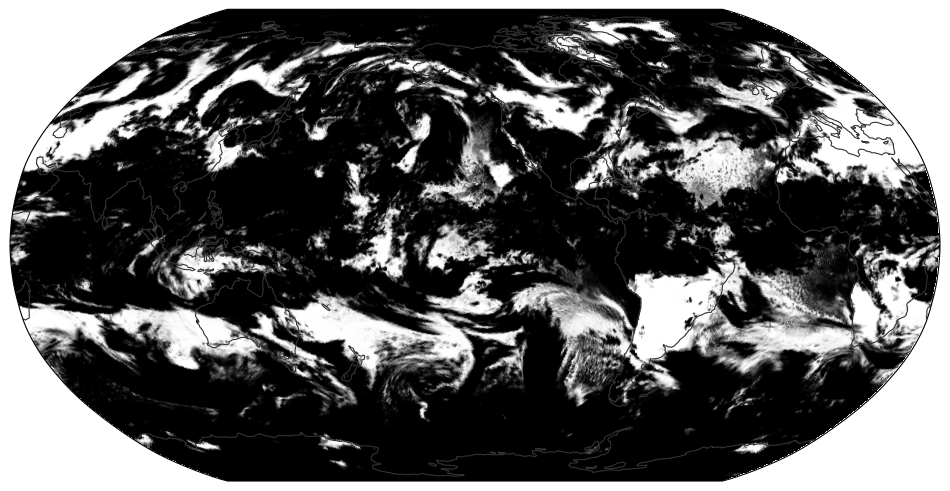

In [28]:
%%time

### Fast way from Jill Zhang

valid = eweights["valid"]
src_idx = eweights["src_idx"]
weights = eweights["weights"]
 
# Use map_blocks to apply the function on Dask chunks
rewrite = da.map_blocks(
    custom_indexing,
    ds_scream[varn2Dout[29]].isel(time=50), src_idx, weights, valid,
    dtype=float  # Specify output dtype
)
egh.healpix_show(rewrite.compute(),cmap='Grays')

### Remap The full data set
Use xarray’s apply_ufunc() function to lift the function onto a full dataset

In [28]:
%%time
### SCREAM version

# if the dataset contains coordinates, then remove them 
#if 'lat' in ds_scream.variables:
#    ds_scream_sm=ds_scream.drop_vars(['lat','lon'])
    
scream_remap = xr.apply_ufunc(
    egr.apply_weights,
    ds_scream,
    kwargs=eweights,
    keep_attrs=True,
    input_core_dims=[["ncol"]],
    output_core_dims=[["cell"]],
    output_dtypes=["f4"],
    vectorize=True,
    dask="parallelized",
    dask_gufunc_kwargs={
        "output_sizes": {"cell": npix},
    },
)
scream_remap

CPU times: user 32.7 ms, sys: 30 μs, total: 32.7 ms
Wall time: 32.3 ms


<xarray.Dataset> Size: 299GB
Dimensions:          (time: 3168, cell: 786432)
Coordinates:
  * time             (time) object 25kB 2019-08-01 03:00:00 ... 2020-09-01 00...
Dimensions without coordinates: cell
Data variables: (12/30)
    rldscs           (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    rlutcs           (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    rlds             (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    rlus             (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    rlut             (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    lwcre            (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    ...               ...
    huss             (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    uas              (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    vas              (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    tauu             (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    tauv             (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
    clt              (time, cell) float32 10GB dask.array<chunksize=(16, 786432), meta=np.ndarray>
Attributes: (12/22)
    institutions:                 LLNL (Lawrence Livermore National Laborator...
    case_t0:                      2019-08-01-00000
    run_t0:                       2019-08-01-00000
    averaging_type:               AVERAGE
    averaging_frequency_units:    nhours
    averaging_frequency:          3
    ...                           ...
    contact:                      e3sm-data-support@llnl.gov
    institution_id:               E3SM-Projet
    realm:                        atmos
    history:                      created on Sun Oct  8 17:33:21 2023
    Conventions:                  CF-1.8
    product:                      model-output

In [30]:
## Rename Variable here...



CPU times: user 5.43 s, sys: 10.2 s, total: 15.6 s
Wall time: 17.8 s


<Figure size 1200x800 with 0 Axes>

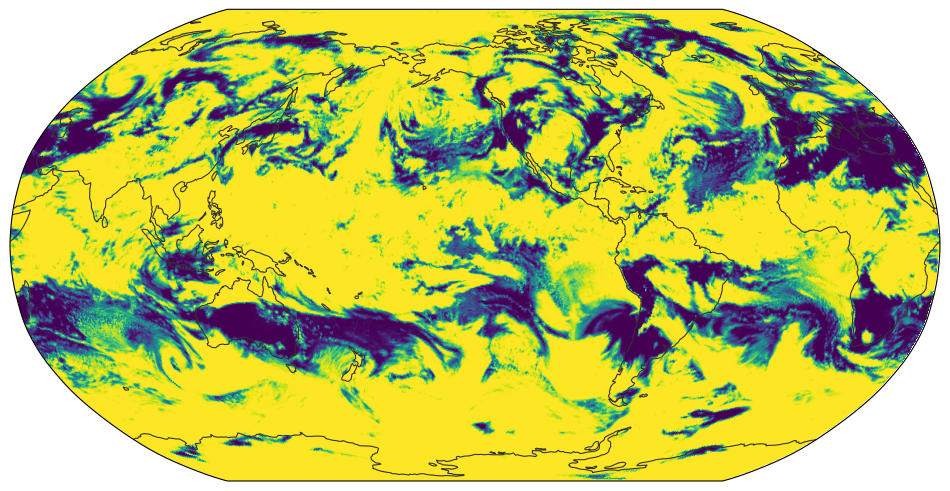

In [33]:
%%time
### Plot it: this is relatively fast (12sec)
#egh.healpix_show(ds_remap.ts.sel(time="1990-12-31").mean("time"))

egh.healpix_show(scream_remap[varn2Dout[29]].isel(time=10))

### Store coordinate Reference System

In [29]:
scream_remap["crs"] = xr.DataArray(
    name="crs",
    data=[],
    dims="crs",
    attrs={
        "grid_mapping_name": "healpix",
        "healpix_nside": 2**zoom,
        "healpix_order": "nest",
    },
)

In [ ]:
#scream_remap[varn2Dout[v]].to_dataset(name=varn2Dout[v])

### Write to Zarr 
Here is where I can loop by variable...(or might be able to just let it go?)

In [34]:
%%time

nv=len(varn2Dout)

# 1 year of 2D level 8 (25km) @3 hrly = 12GB, 2m38s

opth='/pscratch/sd/a/agett/hackathon_zarr_singles/'

#selected
#for v in range(3):
#    ofn=opth+"scream_ne1024_"+varn2Dout[v]+"_hp"+s+"_v4.zarr"
#    store = zarr.storage.DirectoryStore(ofn, dimension_separator="/")
#    scream_remap[varn2Dout[v]].to_dataset(name=varn2Dout[v])\
#    .chunk({"time": 24, "cell": -1})\
#    .to_zarr(store, encoding=get_encoding(scream_remap[varn2Dout[v]].to_dataset(name=varn2Dout[v])))
    
#all
ofn=opth+"scream2D_ne120_all_hp"+s+"_v6.zarr"
#store = zarr.storage.DirectoryStore(ofn, dimension_separator="/")
#scream_remap.chunk({"time": 24, "cell": -1}).to_zarr(store, encoding=get_encoding(scream_remap))

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 10 μs


### Test Read Back

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


CPU times: user 272 ms, sys: 103 ms, total: 375 ms
Wall time: 584 ms


Text(0.5, 1.0, 'clt')

<Figure size 1200x800 with 0 Axes>

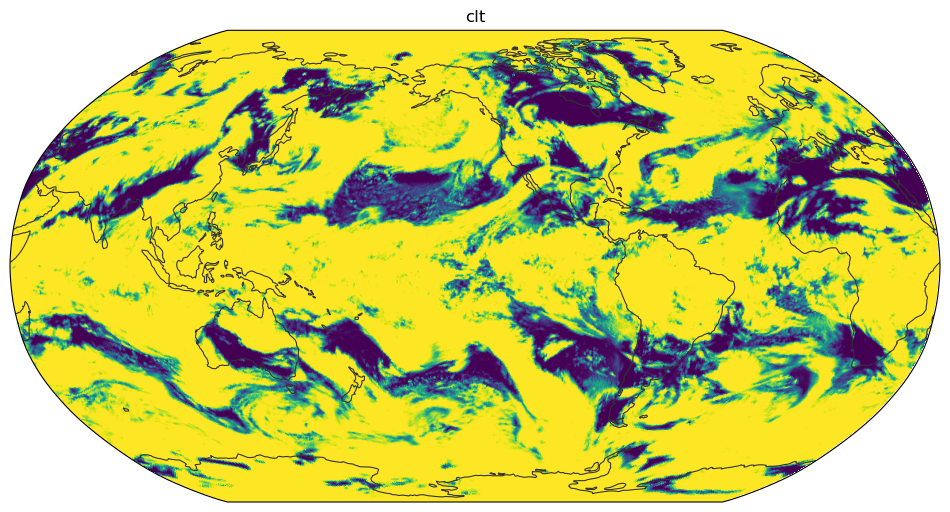

In [46]:
%%time
v=29
ds2=xr.open_dataset(ofn,chunks={"time":24,"cell": -1}) #This makes it a LOT worse on memory and time down below....
#ds2=xr.open_dataset(ofn) # This is better, but should perhaps not be.
egh.healpix_show(ds2[varn2Dout[v]].isel(time=2000))
plt.title(varn2Dout[v])

### Write other resolutions

In [36]:
ds2

<xarray.Dataset> Size: 299GB
Dimensions:          (time: 3168, cell: 786432, crs: 0)
Coordinates:
  * crs              (crs) float64 0B 
  * time             (time) object 25kB 2019-08-01 03:00:00 ... 2020-09-01 00...
Dimensions without coordinates: cell
Data variables: (12/30)
    clt              (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    hflsd            (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    hfssd            (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    huss             (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    lwcre            (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    pr               (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    ...               ...
    tas              (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    tauu             (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    tauv             (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    ts               (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    uas              (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
    vas              (time, cell) float32 10GB dask.array<chunksize=(24, 786432), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          3
    averaging_frequency_units:    nhours
    averaging_type:               AVERAGE
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

In [37]:
import gc

In [38]:
%%time
# Now Loop (max memory is still 25GB for zoom =7 Not using dask right or the assigment should be different...)
dn=ds2
for x in range(7,-1,-1):
    s=str(x)
    fn="scream_ne1024_all_hp"+s+"_v6.zarr"
    print(fn)
    dx=dn.coarsen(cell=4).mean()
    dx['crs'].attrs['healpix_nside'] = 2**int(s)   # Update HEALPix level metadata
    store = zarr.storage.DirectoryStore(opth+fn, dimension_separator="/")
    dx.chunk({"time": 24, "cell": -1}).to_zarr(store, encoding=get_encoding(dx))
    dn=dx
    del dx,store
    gc.collect()

#del dn,dx

scream_ne1024_all_hp7_v6.zarr
scream_ne1024_all_hp6_v6.zarr
scream_ne1024_all_hp5_v6.zarr
scream_ne1024_all_hp4_v6.zarr
scream_ne1024_all_hp3_v6.zarr
scream_ne1024_all_hp2_v6.zarr
scream_ne1024_all_hp1_v6.zarr
scream_ne1024_all_hp0_v6.zarr
CPU times: user 3h 51min 1s, sys: 4h 26min 11s, total: 8h 17min 12s
Wall time: 50min 32s


### Plot Any Resolution

In [ ]:
%%time
s='4'
fn=opth+"scream_ne1024_all_hp"+s+"_v6.zarr"

#fn=opth+'test_dask_70GB_1mo_hp10.zarr'

ds=xr.open_dataset(fn)
egh.healpix_show(ds[varn2Dout[4]].isel(time=1))
plt.title('HealPix Level '+s)